The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


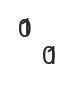

In [20]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import reconstruction_accuracy, VAELoss
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullFVAE
from src.datasets import CDR3BetaDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [42]:
for i in range(5):
    print(f'\n{i}')
    %cat ../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k/args_FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k.txt | tail -n 3


0
Fold: 0Best valid seq acc: 0.9381558377693086
Best valid V acc: 0.9215917117965623
Best valid J acc: 0.993407110901813

1
Fold: 1Best valid seq acc: 0.9566856574804349
Best valid V acc: 0.819038642789821
Best valid J acc: 0.9957587181903864

2
Fold: 2Best valid seq acc: 0.9571465191206466
Best valid V acc: 0.8235571260306243
Best valid J acc: 0.9967020023557126

3
Fold: 3Best valid seq acc: 0.949859586027519
Best valid V acc: 0.7937293729372937
Best valid J acc: 0.9896275341819897

4
Fold: 4Best valid seq acc: 0.9535165230573757
Best valid V acc: 0.9065817409766455
Best valid J acc: 0.9900920028308563


Probly don't need to have that much weight on J gene but for V gene 2.5 seems good.

In [33]:
%ls ../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k

FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.png
args_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.txt
checkpoint_best_fold00_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pt
train_losses_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
train_metrics_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
valid_losses_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
valid_metrics_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
valid_predictions_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.csv


# Reloading models and preds from KCV

In [25]:
len(kcv_df.TRBV_gene.unique())

51

In [27]:
# init stuff
kcv_df = pd.read_csv('../data/filtered/230921_nettcr_immrepnegs_noswap.csv')
test_df = pd.read_csv('../data/filtered/230921_vdjdb_mcpas_filtered_concat_cdr3b_vjgenes')
# Re-init / write down params here ; Taken from the args.txt
max_len, encoding, pad_scale = 23, 'BL50LO', -20
cdr3b_col, v_col, j_col = 'B3', 'TRBV_gene', 'TRBJ_gene'
use_v, use_j, v_dim, j_dim = True, True, 51, 13
hidden_dim, latent_dim = 256, 128
lr, weight_decay = 5e-4, 1e-4
loss_weights = {'weight_seq':3, 'weight_kld':1, 'weight_v':2.5, 'weight_j':2}
n_epochs, batch_size = 2000, 256
# Remaking dataset-loaders
total_dataset = CDR3BetaDataset(kcv_df, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map=None, j_map = None)
total_loader = total_dataset.get_dataloader(batch_size, RandomSampler)
test_dataset = CDR3BetaDataset(kcv_df, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map= total_dataset.v_map, j_map = total_dataset.j_map)
test_loader = test_dataset.get_dataloader(batch_size, SequentialSampler)
folder = '../output/FirstTest_230926_1923_bb76k/'

In [ ]:
# Turns out, I didn't think that different partitions in the train dataset would have different v/j maps.
# As such, I need to save it here and reload it everytime (HARDCODED BAD BEHAVIOUR BUT NO WORKAROUND BECAUSE I NEED TO MAKE SURE THINGS MATCH BETWEEN FOLDS)
# Also need to fix the weights on V and J

In [44]:
pkl_dump(total_dataset.v_map, '../data/Matrices/230927_nettcr_dataset_vmap.pkl')
pkl_dump(total_dataset.j_map, '../data/Matrices/230927_nettcr_dataset_jmap.pkl')

/Users/riwa/Documents/code/tclustr/data/Matrices/230927_nettcr_dataset_vmap.pkl saved.
/Users/riwa/Documents/code/tclustr/data/Matrices/230927_nettcr_dataset_jmap.pkl saved.


In [45]:
models = {}
for i in range(5):
    fn = f'{folder}FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k/checkpoint_best_fold{i:02}_kcv_230921_nettcr_immrepnegs_noswap_f{i:02}_FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k.pt'
    try:
        models[i] = load_checkpoint(FullFVAE(max_len, encoding, pad_scale, 20, use_v, use_j, v_dim, j_dim, nn.SELU(), hidden_dim, latent_dim), fn)
    except:
        print(i)
        d = torch.load(fn)
        print(d['encoder.0.weight'].shape)
    # might as well retrain all folds with adjusted v/j/kld weights

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder_mu.weight', 'encoder_mu.bias', 'encoder_logvar.weight', 'encoder_logvar.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder_sequence.0.weight', 'decoder_sequence.0.bias', 'decoder_sequence.2.weight', 'decoder_sequence.2.bias', 'decoder_v.weight', 'decoder_v.bias', 'decoder_j.weight', 'decoder_j.bias'])
0
torch.Size([261, 523])
odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder_mu.weight', 'encoder_mu.bias', 'encoder_logvar.weight', 'encoder_logvar.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder_sequence.0.weight', 'decoder_sequence.0.bias', 'decoder_sequence.2.weight', 'decoder_sequence.2.bias', 'decoder_v.weight', 'decoder_v.bias', 'decoder_j.weight', 'decoder_j.bias'])
3
torch.Size([261, 523])


In [46]:
models

{1: FullFVAE(
   (encoder): Sequential(
     (0): Linear(in_features=524, out_features=262, bias=True)
     (1): SELU()
     (2): Linear(in_features=262, out_features=256, bias=True)
     (3): SELU()
   )
   (encoder_mu): Linear(in_features=256, out_features=128, bias=True)
   (encoder_logvar): Linear(in_features=256, out_features=128, bias=True)
   (decoder): Sequential(
     (0): Linear(in_features=128, out_features=256, bias=True)
     (1): SELU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): SELU()
   )
   (decoder_sequence): Sequential(
     (0): Linear(in_features=256, out_features=262, bias=True)
     (1): SELU()
     (2): Linear(in_features=262, out_features=460, bias=True)
   )
   (decoder_v): Linear(in_features=256, out_features=51, bias=True)
   (decoder_j): Linear(in_features=256, out_features=13, bias=True)
 ),
 2: FullFVAE(
   (encoder): Sequential(
     (0): Linear(in_features=524, out_features=262, bias=True)
     (1): SELU()
     (2): Linear(